### CMET .mat file processing

In [ ]:
########################
# A function to explore the raw matlab files downloaded
########################

from scipy.io import loadmat
import numpy as np

def explore_mat_file(filepath):
    """
    Load and explore a .mat file with a structured array under key 'f'.
    Prints available fields and shape of each field's data.
    """
    print(f"Loading file: {filepath}")
    data = loadmat(filepath)

    # List all keys in the .mat file
    print("Top-level keys in the .mat file:")
    print(data.keys())
    print()

    if 'f' not in data:
        print("Warning: Key 'f' not found in the .mat file.")
        return

    f = data['f']
    print(f"Type of 'f': {type(f)}")
    print(f"Shape of 'f': {f.shape}")
    print()

    # Check if 'f' is a structured array with named fields
    if not hasattr(f.dtype, 'names') or f.dtype.names is None:
        print("'f' does not appear to be a structured array with named fields.")
        return

    fields = f.dtype.names
    print(f"Fields found in 'f': {fields}")
    print()

    # Since 'f' is likely a 2D array with one element, extract that element
    f0 = f[0, 0]

    # Print shape of arrays stored in each field
    for field in fields:
        try:
            arr = f0[field]
            # Some fields might be scalars, some arrays
            if isinstance(arr, np.ndarray):
                print(f"{field}: shape {arr.shape}, dtype {arr.dtype}")
            else:
                print(f"{field}: type {type(arr)}")
        except Exception as e:
            print(f"Could not access field '{field}': {e}")

    print("\nExample access:")
    # Example: safely access lat, lon, alt if they exist
    for key in ['lat', 'lon', 'alt']:
        if key in fields:
            try:
                val = f0[key]
                print(f"{key} sample value (shape {val.shape}):")
                print(val)
            except Exception as e:
                print(f"Could not access {key}: {e}")
        else:
            print(f"Field '{key}' not found in 'f'.")

# Example usage:
explore_mat_file("/content/drive/MyDrive/MScThesis/from_mat_files/170112a.mat")


Loading file: /content/drive/MyDrive/MScThesis/170112a.mat
Top-level keys in the .mat file:
dict_keys(['__header__', '__version__', '__globals__', 'f'])

Type of 'f': <class 'numpy.ndarray'>
Shape of 'f': (1, 1)

Fields found in 'f': ('id', 'CMD', 'loni', 'lati', 'alti', 'pbos', 'data', 'sbd', 'msg', 'hms', 'hr', 'mn', 'sc', 'lat_dg', 'lat_mf', 'lat_mn', 'lat_sc', 'lat', 'lon_dg', 'lon_mf', 'lon_mn', 'lon_sc', 'lon', 'alt', 'rhf', 'rh', 'ta', 'pb', 'pa', 'dp', 'vb', 'is', 'tb', 'pp', 'ppa', 'trm', 'cmdn', 'mode', 'sat', 'z', 'zmin', 'zmax', 'wmin', 'wmax', 'concy', 'datcy', 't1', 't2', 'tcmd', 'flt', 'yr', 'jd', 'mo', 'dy', 't', 'sza', 'psat', 'pw', 'td', 'pd', 'xw', 'fw', 'wv', 'qv', 'ra', 'pt', 'vpt', 'ptm', 'zb', 'zp', 'zo', 'e', 'if', 'ug', 'vg', 'wo', 'dt', 'dtuv', 'ws', 'wd', 'wdn', 'wdo', 'wdc', 'riz', 'rin', 'dudz', 'dvdz', 'dtdz', 'dudz_sd', 'dvdz_sd', 'dtdz_sd', 'ri')

id: shape (1,), dtype <U16
CMD: shape (26, 19), dtype uint16
loni: shape (1, 1), dtype float64
lati: shape (

In [ ]:
########################
# Converting the .mat files into csv's
# NOTE: This saves the file in the temporary storage so you have to move it
# NOTE: I created this because most variables have a value for each observational
#       point but some (like CMD or id only have one or a few so they are separated
#       into arrays_1d and scalars)
########################

!pip install pymatreader

from pymatreader import read_mat

data = read_mat("/content/drive/MyDrive/MScThesis/from_mat_files/170112a.mat")
f = data['f']  # Your data dictionary

arrays_1d = {}
scalars = {}

# Detect all 1D arrays and their lengths
lengths = set()

for key, val in f.items():
    if isinstance(val, np.ndarray):
        if val.ndim == 1:
            lengths.add(val.shape[0])
            arrays_1d[key] = val
        else:
            scalars[key] = val
    else:
        scalars[key] = val

# Check if all 1D arrays have the same length
if len(lengths) == 1:
    array_length = lengths.pop()
    print(f"Detected 1D arrays all have length: {array_length}")
else:
    print(f"Warning: Found 1D arrays of different lengths: {lengths}")
    # You can decide how to handle this case:
    # For now, only keep arrays with the most common length
    from collections import Counter
    length_counts = Counter([val.shape[0] for val in arrays_1d.values()])
    most_common_length = length_counts.most_common(1)[0][0]
    print(f"Using arrays of length {most_common_length} for CSV")
    arrays_1d = {k: v for k, v in arrays_1d.items() if v.shape[0] == most_common_length}
    array_length = most_common_length

# --- Save arrays CSV ---

df_arrays = pd.DataFrame(arrays_1d)
df_arrays.to_csv('arrays_1d.csv', index=False)
print("Saved arrays_1d.csv")

# --- Prepare scalars CSV in long format ---

rows = []

# Handle CMD separately if present (flatten and save each element as a row)
if 'CMD' in scalars:
    cmd_array = scalars.pop('CMD')
    cmd_flat = cmd_array.flatten()
    for i, v in enumerate(cmd_flat):
        rows.append({'variable': f'CMD_{i}', 'value': v})

for key, val in scalars.items():
    if isinstance(val, np.ndarray):
        if val.size == 1:
            rows.append({'variable': key, 'value': val.item()})
        else:
            flat = val.flatten()
            for i, v in enumerate(flat):
                rows.append({'variable': f'{key}_{i}', 'value': v})
    else:
        rows.append({'variable': key, 'value': val})

df_scalars = pd.DataFrame(rows)
df_scalars.to_csv('scalars_long_format.csv', index=False)
print("Saved scalars_long_format.csv")


Detected 1D arrays all have length: 2449
Saved arrays_1d.csv
Saved scalars_long_format.csv


### CMET .txt file processing

In [ ]:
####################
# From raw .txt files
# Just viewing the file, checking the structure and NaN's
####################

import pandas as pd
import numpy as np

file_path = "/content/drive/MyDrive/MScThesis/from_txt_files/170112a.txt"

# Read whitespace-separated file (tabs OR spaces)
df = pd.read_csv(
    file_path,
    sep=r"\s+",        # any whitespace
    header=None,       # no header in file
    engine="python",
    na_values=["NaN"]
)

print("File loaded successfully.")

# Checking size and shape
print("\nShape (rows, columns):", df.shape)
print("\nData types:")
print(df.dtypes)

# Checking how many NaN's are present
print("\nNaN count per column:")
print(df.isna().sum())

# Check if columns have different data types within
for col in df.columns:
    print(f"\nColumn {col}:")
    print("dtype:", df[col].dtype)
    print("Python types inside:")
    print(df[col].apply(type).value_counts())

print(df.describe()) # gives the statistics of each column and automatically excludes NaN's



File loaded successfully.

Shape (rows, columns): (2920, 7)

Data types:
0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
dtype: object

NaN count per column:
0      1
1    193
2    195
3      0
4      0
5      0
6      0
dtype: int64

Non-NaN count per column:
0    2919
1    2727
2    2725
3    2920
4    2920
5    2920
6    2920
dtype: int64

Column 0:
dtype: float64
Python types inside:
0
<class 'float'>    2920
Name: count, dtype: int64

Column 1:
dtype: float64
Python types inside:
1
<class 'float'>    2920
Name: count, dtype: int64

Column 2:
dtype: float64
Python types inside:
2
<class 'float'>    2920
Name: count, dtype: int64

Column 3:
dtype: float64
Python types inside:
3
<class 'float'>    2920
Name: count, dtype: int64

Column 4:
dtype: float64
Python types inside:
4
<class 'float'>    2920
Name: count, dtype: int64

Column 5:
dtype: float64
Python types inside:
5
<class 'float'>    2920
Name: count, dtype: int64

Column 6:
dtype: f

In [ ]:
####################
# This file creates a new .csv which adds timestamps to the txt files in lots
# of different formats based on the julian day in the first column
####################

# ===== CONFIG =====
file_path = "/content/drive/MyDrive/MScThesis/from_txt_files/171122a.txt"   # input text file
output_csv = "171122a_time.csv" # output CSV
year = 2017                       # year to use for Julian day

# Read raw file
df = pd.read_csv(file_path, sep=r'\s+', header=None, engine='python')

# Convert Julian day to datetime
df['datetime'] = pd.to_datetime(df[0] - 1, unit='D', origin=pd.Timestamp(f'{year}-01-01'))

# Extract components with nullable integers
df['year']   = df['datetime'].dt.year.astype('Int64')
df['month']  = df['datetime'].dt.month.astype('Int64')
df['day']    = df['datetime'].dt.day.astype('Int64')
df['hour']   = df['datetime'].dt.hour.astype('Int64')
df['minute'] = df['datetime'].dt.minute.astype('Int64')
df['second'] = df['datetime'].dt.second.astype('Int64')

# Extra formats
df['HHMMSS'] = df['datetime'].dt.strftime('%H%M%S')
df['dd-mm']  = df['datetime'].dt.strftime('%d-%m')
df['datetime_iso'] = df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f000')

# Save to new CSV
df.to_csv(output_csv, index=False)

print(f"New CSV saved: {output_csv}")

New CSV saved: 171122a_time.csv


### Radiosonde data processing

In [ ]:
####################
# adding time infomation to Halley radiosonde launches
# all in UTC
####################

import pandas as pd
from datetime import timedelta

# ===== CONFIG =====
file_path = "/content/drive/MyDrive/MScThesis/radiosondes_Halley/raw_dat_files/20170119.dat"
output_csv = "20170119_time.csv"

# ===== STEP 1: Read the file =====
# Read first line separately (launch info)
with open(file_path, 'r') as f:
    first_line = f.readline().strip()

# Extract launch info: Year, Month, Day, Hour, Minute
launch_info = first_line.split()
launch_year   = int(launch_info[0])
launch_month  = int(launch_info[1])
launch_day    = int(launch_info[2])
launch_hour   = int(launch_info[3])
launch_minute = int(launch_info[4])
# ignore the 6th field

launch_datetime = pd.Timestamp(year=launch_year,
                               month=launch_month,
                               day=launch_day,
                               hour=launch_hour,
                               minute=launch_minute)

# ===== STEP 2: Read the rest of the file =====
# 2nd row onwards — all data
# There are 9 columns: Minutes, Seconds, Pressure, Height, Temp, Humidity, Dewpoint, WindDir, WindSpd
df = pd.read_csv(file_path, sep=r'\s+', header=None, skiprows=1,
                 names=['minutes_into_flight', 'seconds_into_flight', 'pressure',
                        'height', 'temperature', 'humidity', 'dewpoint',
                        'wind_dir', 'wind_speed'],
                 engine='python')

# ===== STEP 3: Compute absolute datetime for each row =====
df['datetime'] = df.apply(
    lambda row: launch_datetime + timedelta(minutes=row['minutes_into_flight'],
                                            seconds=row['seconds_into_flight']),
    axis=1
)

# ===== STEP 4: Extract extra columns =====
# Year, month, day, hour, minute, second
df['year']   = df['datetime'].dt.year
df['month']  = df['datetime'].dt.month
df['day']    = df['datetime'].dt.day
df['hour']   = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
# HHMMSS with leading zeros
df['HHMMSS'] = df['datetime'].apply(lambda x: f"{x.hour:02d}{x.minute:02d}{x.second:02d}")
# dd-mm
df['dd-mm'] = df['datetime'].dt.strftime('%d-%m')
# Optional ISO format
df['datetime_iso'] = df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f000')
# Decimal Julian day
df['julian_day_decimal'] = df['datetime'].apply(
    lambda x: x.dayofyear + (x.hour*3600 + x.minute*60 + x.second)/86400)

# ===== STEP 5: Save to CSV =====
df.to_csv(output_csv, index=False)

print(f"New CSV saved: {output_csv}")

New CSV saved: 20170119_time.csv


### ERA5 CDS API Downloads

In [ ]:
!pip install netCDF4 cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 41.3 MB/s eta 0:00:00


In [ ]:
import netCDF4 # netCDF4: reads .nc files efficiently
import xarray  # xarray: essential for ERA5 (lazy loading, metadata)
import dask    # dask: chunked, out-of-core processing (critical for large data)
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy

ModuleNotFoundError: No module named 'netCDF4'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/MScThesis/ERA5")
print(os.getcwd())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/MScThesis/ERA5


In [ ]:
url = 'url: https://cds.climate.copernicus.eu/api'
key = 'key: 52e1f859-2274-4661-a9be-3a4005e8234e'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api
key: 52e1f859-2274-4661-a9be-3a4005e8234e


In [ ]:
!pip install "cdsapi>=0.7.7"

To check status of download on the web (after login): https://cds.climate.copernicus.eu/requests?tab=all

In [ ]:
################################
# To fill in before a request: #
################################

path = "/content/drive/MyDrive/MScThesis/ERA5"
filename = "170112a_T_500_1501.nc"      # <---Must edit before a request (check extension is correct)

output_file = os.path.join(path, filename)

In [ ]:
import cdsapi # don't move this to the top, idk why just don't

dataset = "reanalysis-era5-pressure-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": ["temperature"],
    "year": ["2017"],
    "month": ["01"],
    "day": [
        "15"
    ],
    "time": [
        "00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00",
        "07:00", "08:00", "09:00", "10:00", "11:00", "12:00", "13:00",
        "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "pressure_level": ["500"
    ],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [-72, -180, -88, 0]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(output_file)

2026-02-03 13:03:33,759 INFO Request ID is 5e46a64b-959b-478e-9864-dbc1a72843aa
INFO:ecmwf.datastores.legacy_client:Request ID is 5e46a64b-959b-478e-9864-dbc1a72843aa
2026-02-03 13:03:33,943 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-02-03 13:30:02,087 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


19e6926e540f9b6ab520826ade5bafd5.nc:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

'/content/drive/MyDrive/MScThesis/ERA5/170112a_T_500_1501.nc'

In [ ]:
# To show metadata and structure on an ERA5 netCDF file
import xarray as xr
data = xr.open_dataset('/content/drive/MyDrive/MScThesis/ERA5/170112a_T_500_1501.nc')
data

<xarray.Dataset> Size: 5MB
Dimensions:         (valid_time: 24, pressure_level: 1, latitude: 65,
                     longitude: 721)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 192B 2017-01-15 ... 2017-01-1...
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 520B -72.0 -72.25 -72.5 ... -87.75 -88.0
  * longitude       (longitude) float64 6kB -180.0 -179.8 -179.5 ... -0.25 0.0
    number          int64 8B ...
    expver          (valid_time) <U4 384B ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-03T13:28 GRIB to CDM+CF via cfgrib-0.9.1...

###Mapping

In [ ]:
pip install pandas matplotlib cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 39.5 MB/s eta 0:00:00


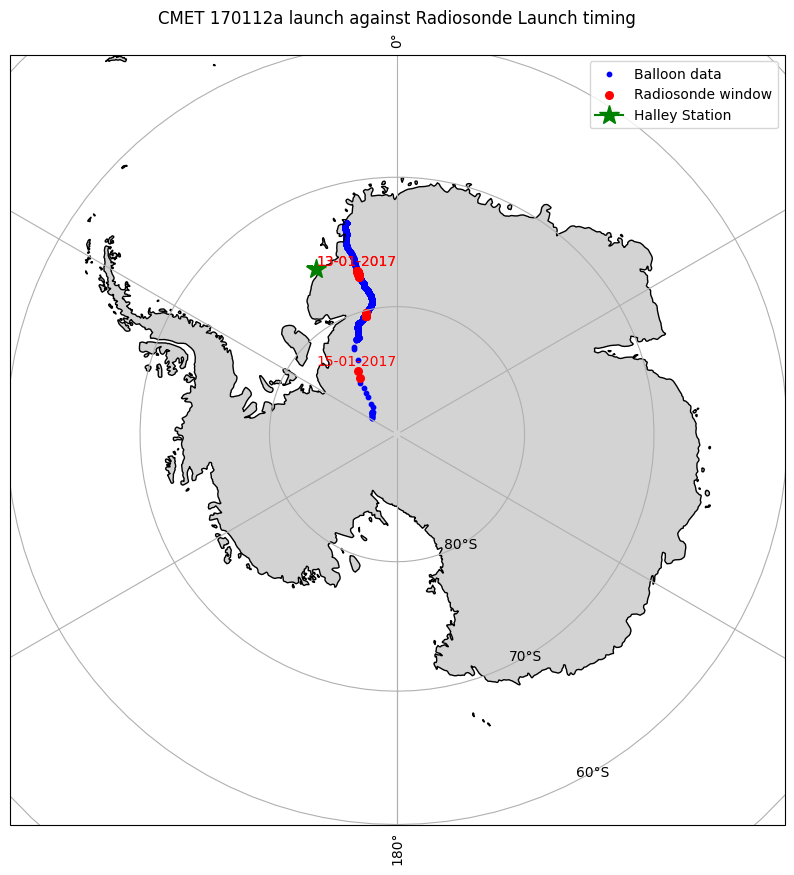

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ===== STEP 1: Load the weather balloon data =====
# First 3 columns: jd, lat, lon
# No header, sep could be space or tab
balloon_file = "/content/drive/MyDrive/MScThesis/from_txt_files/170112a.txt"

df_balloon = pd.read_csv(
    balloon_file,
    sep=r'\s+',
    header=None,
    engine='python',
    usecols=[0,1,2],
    names=['jd','lat','lon']
)

# ===== STEP 2: Load radiosonde launch data =====
radiosonde_file = "/content/drive/MyDrive/MScThesis/radiosondes_Halley/radisondes_times.csv"
df_launch = pd.read_csv(radiosonde_file)

# df_launch should have columns: 'radiosonde', 'jd_start', 'jd_end'

# ===== STEP 3: Check which balloon points are within any radiosonde window =====
# Create a boolean column for highlight
df_balloon['highlight'] = False
df_balloon['radiosonde_label'] = ''

for idx, row in df_launch.iterrows():
    mask = (df_balloon['jd'] >= row['jd_start']) & (df_balloon['jd'] <= row['jd_end'])
    df_balloon.loc[mask, 'highlight'] = True
    df_balloon.loc[mask, 'radiosonde_label'] = row['radiosonde']

# ===== STEP 4: Plot the map =====
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Antarctica region

# Add coastlines and land features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.gridlines(draw_labels=True)

# Plot all balloon points
ax.scatter(df_balloon['lon'], df_balloon['lat'], s=10, c='blue', transform=ccrs.PlateCarree(), label='Balloon data')

# Highlight points within radiosonde launch windows
highlight = df_balloon[df_balloon['highlight']]
ax.scatter(highlight['lon'], highlight['lat'], s=30, c='red', transform=ccrs.PlateCarree(), label='Radiosonde window')

# Add a single label per radiosonde launch, next to the first highlighted point
for rs in df_launch['radiosonde']:
    subset = df_balloon[df_balloon['radiosonde_label'] == rs]
    if not subset.empty:
        first_point = subset.iloc[0]  # pick the first highlighted point
        ax.text(
            first_point['lon'],
            first_point['lat'] + 0.2,  # small vertical offset
            rs,
            color='red',
            fontsize=10,
            ha='center',
            va='bottom',
            transform=ccrs.PlateCarree()
        )

# ===== ADD HALLEY STATION =====
halley_lat = -75.6111   # 75°36'40"S
halley_lon = -26.2669   # 26°16'1"W

# Plot the station and give it a label for the legend
halley_plot = ax.plot(
    halley_lon, halley_lat,
    marker='*', color='green', markersize=15,
    transform=ccrs.PlateCarree(),
    label='Halley Station'
)[0]  # plot returns a list of Line2D, take first element

plt.title("CMET 170112a launch against Radiosonde Launch timing")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)


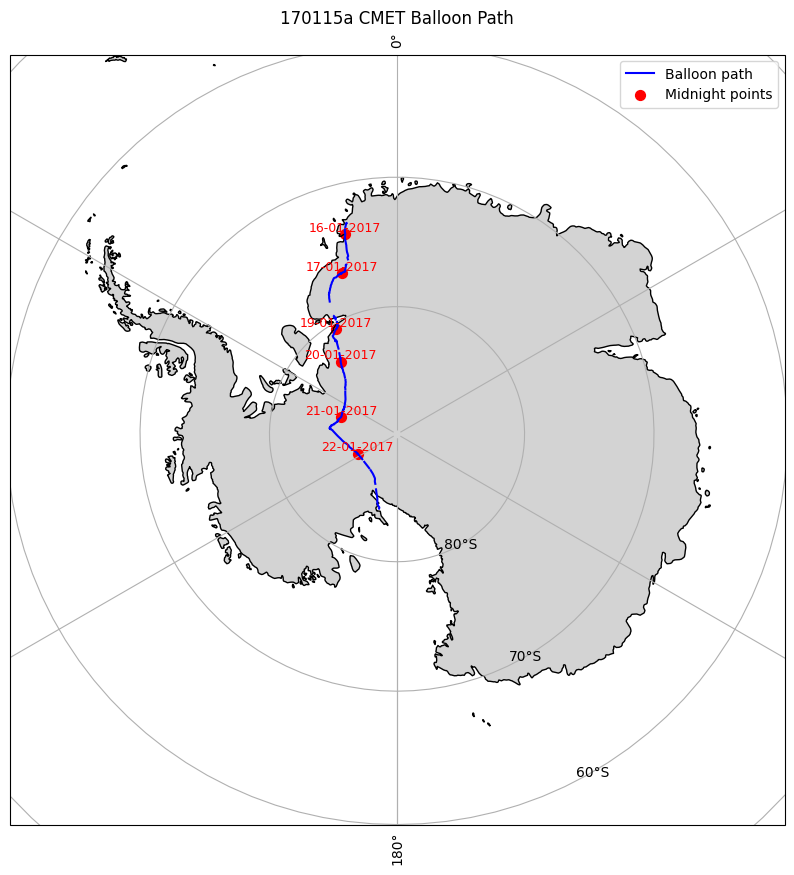

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta

# ===== STEP 1: Load the balloon data =====
balloon_file = "/content/drive/MyDrive/MScThesis/from_txt_files/170115a.txt"
df_balloon = pd.read_csv(
    balloon_file,
    sep=r'\s+',
    header=None,
    engine='python',
    usecols=[0,1,2],
    names=['jd','lat','lon']
)

# ===== STEP 2: Convert Julian day to datetime =====
# Assuming all JD are in 2017
year = 2017
# Drop rows with missing JD
df_balloon = df_balloon.dropna(subset=['jd'])

# Convert JD to float
df_balloon['jd'] = df_balloon['jd'].astype(float)

# Convert Julian day to datetime (ERA5-style, origin at Jan 1, 2017)
year = 2017
df_balloon['datetime'] = pd.to_datetime(df_balloon['jd'] - 1, unit='D', origin=pd.Timestamp(f'{year}-01-01'))

# ===== STEP 3: Find points at midnight =====
# Midnight is when hour == 0 and minute == 0
df_midnight = df_balloon[df_balloon['datetime'].dt.hour == 0]
# Alternatively, if no hourly info, pick the first point of each integer JD:
df_midnight = df_balloon[df_balloon['jd'].astype(int).diff() != 0]  # first point of each day

# ===== STEP 4: Plot map =====
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.gridlines(draw_labels=True)

# Plot full balloon path
ax.plot(df_balloon['lon'], df_balloon['lat'], c='blue', transform=ccrs.PlateCarree(), label='Balloon path')

# Highlight midnight points
ax.scatter(df_midnight['lon'], df_midnight['lat'], c='red', s=50, transform=ccrs.PlateCarree(), label='Midnight points')

# Label each midnight point with DD-MM-2017
for idx, row in df_midnight.iterrows():
    label_text = row['datetime'].strftime('%d-%m-2017')
    ax.text(row['lon'], row['lat'], label_text, color='red', fontsize=9,
            ha='center', va='bottom', transform=ccrs.PlateCarree(), clip_on=False)

plt.title("170115a CMET Balloon Path")
plt.legend()
plt.show()


### Plotting

### Other analyses that I could use again

1. A script to match the closest AMPS meteogram station to the location of each data point in the .kml file (which I manually converted into a csv. Already done for the 170 flights. AMPS meteogram stations converted into a csv using code in the grave)

In [ ]:
##################
# Matching the closest AMPS meteogram station in domain 2 to points along the trajectory
# Note that the csv files of the balloons are created from the .kml files
# ^ This is done manually by opening the file from my folder and copying the relevant data
#   into a text file then saving as a csv
##################

import csv
import math

def haversine(lon1, lat1, lon2, lat2):
    # Calculate the great circle distance between two points on the earth (in kilometers)
    R = 6371  # Earth radius in km
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Load meteogram stations

CMET = "/content/drive/MyDrive/MScThesis/from_mat_files/170115a.csv"
AMPS_stations = "/content/drive/MyDrive/MScThesis/AMPS/AMPS_domain2_meteogram_sites.csv"
output = "/content/drive/MyDrive/MScThesis/AMPS/170115a_withAMPSstations.csv"

stations = []
with open(AMPS_stations, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        stations.append({
            'abbrev': row['abbrev'],
            'lat': float(row['latitude']),
            'lon': float(row['longitude'])
        })


# Process points and find closest station
with open(CMET, 'r') as infile, open(output, 'w', newline='') as outfile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames + ['AMPS_meteogram_stn']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    for row in reader:
        point_lon = float(row['lon'])
        point_lat = float(row['lat'])

        # Find closest station
        closest_station = None
        min_distance = float('inf')
        for st in stations:
            dist = haversine(point_lon, point_lat, st['lon'], st['lat'])
            if dist < min_distance:
                min_distance = dist
                closest_station = st['abbrev']

        # Add closest station abbrev to row
        row['AMPS_meteogram_stn'] = closest_station
        writer.writerow(row)

print("Done!")

Done!


### Grave

In [ ]:
#########
# Converting radiosonde .dat files from Halley Station into .csv
# Data from BAS (see email from Steve Colwell)
#########
import pandas as pd
from google.colab import files

# Step 1: Upload multiple .dat files
print("Upload your tab-delimited .dat files:")
uploaded = files.upload()

# Step 2: Loop through each uploaded file and convert to .csv
for filename in uploaded.keys():
    try:
        # Read the .dat file as tab-delimited
        df = pd.read_csv(filename, delimiter='\t')

        # Create the .csv filename
        csv_filename = filename.rsplit('.', 1)[0] + '.csv'

        # Save as .csv
        df.to_csv(csv_filename, index=False)

        print(f"Converted {filename} to {csv_filename}")

        # Step 3: Download the .csv file
        files.download(csv_filename)

    except Exception as e:
        print(f"Failed to convert {filename}: {e}")


Upload your tab-delimited .dat files:


Saving 20170119.dat to 20170119 (1).dat
Saving 20170110.dat to 20170110 (1).dat
Saving 20170117.dat to 20170117 (1).dat
Saving 20170118.dat to 20170118 (1).dat
Saving 20170114.dat to 20170114 (1).dat
Saving 20170115.dat to 20170115 (1).dat
Saving 20170113.dat to 20170113 (1).dat
Saving 20170116.dat to 20170116 (1).dat
Saving 20170111.dat to 20170111 (1).dat
Saving 20170112.dat to 20170112 (1).dat
Converted 20170119 (1).dat to 20170119 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170110 (1).dat to 20170110 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170117 (1).dat to 20170117 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170118 (1).dat to 20170118 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170114 (1).dat to 20170114 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170115 (1).dat to 20170115 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170113 (1).dat to 20170113 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170116 (1).dat to 20170116 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170111 (1).dat to 20170111 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converted 20170112 (1).dat to 20170112 (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#########
# Converting a text file of AMPS meteogram sites into csv
# Data from: https://www2.mmm.ucar.edu/rt/amps/information/meteogram_sites/index.html
#########

""" Example:
 abbrev | site name                      | latitude | longitude
--------+--------------------------------+----------+-----------
 abn    | ABN                            | -71.1667 |  111.4000
 aboa   | DML_Wasa_Aboa                  | -73.0300 |  -13.4100
 adare  | USAP_Cape_Adare                | -71.2833 |  170.2330
 """

import csv

input_file  = '/content/drive/MyDrive/MScThesis/AMPS/AMPS_domain2_meteogram_sites.txt'
output_file = '/content/drive/MyDrive/MScThesis/AMPS/AMPS_domain2_meteogram_sites.csv'

with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    writer = csv.writer(outfile)

    for line in infile:
        line = line.strip()
        # Skip empty lines or separator lines
        if not line or set(line) <= set('-+'):
            continue

        # Split by pipe and strip whitespace
        fields = [field.strip() for field in line.split('|')]

        # Write header or data rows
        writer.writerow(fields)

print(f"Conversion complete! CSV saved as {output_file}")

###########
# Then I am converting this into KML to add it to my google earth map for visualisation
###########

input_file = output_file  # CSV file generated from your text file
kml_file = '/content/drive/MyDrive/MScThesis/AMPS/AMPS_domain2_meteogram_sites.kml'

# KML file header and footer templates
kml_header = '''<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document>
    <name>Sites Abbreviations</name>
'''

kml_footer = '''  </Document>
</kml>'''

with open(input_file, 'r') as csvfile, open(kml_file, 'w') as kml:
    reader = csv.DictReader(csvfile)
    kml.write(kml_header)

    for row in reader:
        abbrev = row['abbrev']
        lat = row['latitude']
        lon = row['longitude']

        # Write a Placemark for each site with abbreviation as the label
        placemark = f'''
    <Placemark>
      <name>{abbrev}</name>
      <Point>
        <coordinates>{lon},{lat},0</coordinates>
      </Point>
    </Placemark>
'''
        kml.write(placemark)

    kml.write(kml_footer)

print(f"KML file created: {kml_file}")

In [1]:
pip install netCDF4 xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00


In [3]:
####
# This was just to read sea-level pressure anomaly data from Antarctica in January 2017
# from: https://data.seaiceportal.de/relaunch/SLP.php?region=s&minYear=2017&minMonth=1&maxYear=2017&maxMonth=1&submit1=New+search&lang=en&active-tab2=clima&active-tab1=derived_products&ice-type=clima&resolution=monthly&parameter=SLP
#
from netCDF4 import Dataset

# Open the .nc file
dataset = Dataset('/content/drive/MyDrive/MScThesis/slp_201701.nc', 'r')

# Print the dataset structure
print(dataset)

# Access variables
print(dataset.variables.keys())

# Read a variable, e.g. temperature
slp = dataset.variables['slp'][:]

print(slp)

# Close the dataset
dataset.close()


<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history: Mon Jan 20 14:05:15 2020: cdo splitmon slp_2017.nc slp_2017
Mon Jan 20 14:05:14 2020: cdo splityear recent.nc slp_
Mon Jan 20 14:04:43 2020: cdo selyear,2002/2019 slp.mon.mean.nc recent.nc
Thu May  4 18:12:35 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc ./surface/slp.mon.mean.nc
Mon Jul  5 23:22:35 1999: ncrcat slp.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/slp.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Thu Oct 26 23:42:16 1995 from pre.sig995.85.nc
created 95/02/06 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.
    platform: Model
    NCO